# 食品原材料分析・分量推定システム

このノートブックは、食品の原材料リストから各原材料の使用量を推定するシステムです。
日本の食品表示法に基づき、原材料が使用量の多い順に記載されているという原則を利用します。

## 1. 必要なライブラリのインポート

In [13]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import json
import openai
import matplotlib.pyplot as plt
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

## 2. OpenAI APIキーの設定

**注意**: このAPIキーはテスト用に一時的にハードコーディングされています。実際の運用では環境変数や安全な方法で管理してください。

In [ ]:
# TEST用キー - すぐに無効化される一時的なキーです
openai.api_key = "API_KEY"

## 3. 原材料情報をOpenAI APIで解析する関数

In [3]:
def extract_ingredients_from_text(text):
    """
    テキストから原材料情報を抽出し、JSON形式で返す
    
    Parameters:
    -----------
    text : str
        原材料情報を含むテキスト
    
    Returns:
    --------
    dict
        JSON形式の原材料情報
    """
    # OpenAIのAPIを呼び出して原材料を分析
    response = openai.chat.completions.create(
        model="gpt-4-0125-preview",
        messages=[
            {
                "role": "system", 
                "content": """
                あなたは食品の原材料を分析する専門家です。
                与えられた原材料リストを分析し、以下の情報を含むJSONを生成してください:
                1. 各原材料の名前
                2. その原材料が何番目に記載されているか（使用量の多い順）
                3. 主要な栄養素カテゴリ（タンパク質源、炭水化物源、脂質源、調味料など）
                4. 一般的な100gあたりの栄養成分の推定値（カロリー、タンパク質、脂質、炭水化物、塩分）

                JSONは厳密に以下の形式で返してください:
                {
                    "ingredients": [
                        {
                            "name": "原材料名",
                            "position": 順位数値,
                            "category": "カテゴリ",
                            "estimated_nutrition": {
                                "calories": 数値,
                                "protein": 数値,
                                "fat": 数値,
                                "carbs": 数値,
                                "salt": 数値
                            }
                        },
                        ...
                    ]
                }
                """
            },
            {
                "role": "user", 
                "content": f"以下の原材料リストを分析してください: {text}"
            }
        ],
        temperature=0.1,
        response_format={"type": "json_object"}
    )
    
    # APIからの応答を解析
    result = response.choices[0].message.content
    
    # JSONデータを解析
    try:
        ingredients_data = json.loads(result)
        return ingredients_data
    except json.JSONDecodeError:
        return {"error": "JSONの解析に失敗しました。"}

## 4. 原材料の分量を推定する関数

In [4]:
def estimate_ingredient_amounts(ingredients_df, target_nutrition, constraints=None):
    """
    原材料の分量を栄養成分表示から推定する関数
    
    Parameters:
    -----------
    ingredients_df : DataFrame
        各原材料の栄養成分情報（カロリー、タンパク質、脂質、炭水化物、塩分）を含むデータフレーム
    target_nutrition : dict
        目標とする製品の栄養成分情報
    constraints : dict, optional
        原材料の使用制約（最小量、最大量など）
    
    Returns:
    --------
    DataFrame
        推定された各原材料の使用量と割合
    """
    # 原材料数と栄養成分数を取得
    n_ingredients = len(ingredients_df)
    nutrition_columns = ['calories', 'protein', 'fat', 'carbs', 'salt']
    
    # 目標栄養成分値をベクトル化
    target_values = np.array([target_nutrition[col] for col in nutrition_columns])
    
    # 各原材料の栄養成分行列を作成
    nutrition_matrix = ingredients_df[nutrition_columns].values
    
    # 目的関数: 推定栄養成分と目標栄養成分の二乗誤差 + 原材料順序に関するペナルティ
    def objective_function(amounts):
        estimated_nutrition = np.dot(amounts, nutrition_matrix)
        # 栄養成分の誤差
        nutrition_error = np.sum((estimated_nutrition - target_values) ** 2)
        
        # 原材料の順序を考慮したペナルティ
        order_penalty = 0
        for i in range(n_ingredients):
            for j in range(i+1, n_ingredients):
                # positionが小さい（前に記載されている）原材料は、positionが大きい原材料より
                # 多く使われているはずなので、そうでない場合にペナルティを与える
                if ingredients_df.iloc[i]['position'] < ingredients_df.iloc[j]['position']:
                    if amounts[i] < amounts[j]:
                        order_penalty += 10 * (amounts[j] - amounts[i])
        
        return nutrition_error + order_penalty
    
    # 制約条件: 全ての原材料の合計が100%（または指定された総量）になること
    total_amount = target_nutrition.get('total_amount', 100)
    constraints_list = [{'type': 'eq', 'fun': lambda x: np.sum(x) - total_amount}]
    
    # 境界条件: 全ての原材料は0以上
    bounds = [(0, None) for _ in range(n_ingredients)]
    
    # 初期値: 原材料の記載順位に基づいて初期値を設定
    positions = ingredients_df['position'].values
    # 逆数を取って、位置が小さい（前に記載されている）ほど大きな初期値を持つようにする
    initial_weights = 1 / positions
    # 合計が総量になるように正規化
    initial_guess = initial_weights * (total_amount / np.sum(initial_weights))
    
    # 最適化問題を解く
    result = minimize(
        objective_function, 
        initial_guess, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints_list
    )
    
    # 結果をデータフレームにまとめる
    estimated_amounts = result.x
    
    # 使用分量順にソート（推定量ベース）
    sorted_indices = np.argsort(estimated_amounts)[::-1]
    
    output_df = pd.DataFrame({
        '原材料': ingredients_df.index[sorted_indices],
        '推定量(g)': np.round(estimated_amounts[sorted_indices], 2),
        '割合(%)': np.round((estimated_amounts[sorted_indices] / total_amount) * 100, 2),
        '表示順位': ingredients_df.iloc[sorted_indices]['position'].values
    })
    
    return output_df

## 5. OpenAI APIから取得した原材料JSONをDataFrameに変換する関数

In [5]:
def ingredients_json_to_dataframe(ingredients_data):
    """
    OpenAI APIから取得した原材料JSONをDataFrameに変換する
    
    Parameters:
    -----------
    ingredients_data : dict
        原材料情報を含むJSON
    
    Returns:
    --------
    DataFrame
        栄養成分情報を含むDataFrame
    """
    data = []
    index = []
    
    for ingredient in ingredients_data['ingredients']:
        name = ingredient['name']
        position = ingredient['position']
        nutrition = ingredient['estimated_nutrition']
        
        data.append({
            'position': position,
            'calories': nutrition['calories'],
            'protein': nutrition['protein'],
            'fat': nutrition['fat'],
            'carbs': nutrition['carbs'],
            'salt': nutrition['salt'],
            'category': ingredient['category']
        })
        
        index.append(name)
    
    return pd.DataFrame(data, index=index)

## 6. 結果を可視化する関数

In [6]:
def visualize_results(estimated_amounts):
    """
    推定された原材料の分量をグラフで表示する
    
    Parameters:
    -----------
    estimated_amounts : DataFrame
        推定された各原材料の使用量と割合
    """
    plt.figure(figsize=(12, 6))
    
    # 棒グラフ (推定量)
    plt.subplot(1, 2, 1)
    bars = plt.barh(estimated_amounts['原材料'], estimated_amounts['推定量(g)'], color='skyblue')
    plt.xlabel('推定使用量 (g/100g)')
    plt.title('原材料の推定使用量')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    # 棒グラフに値を表示
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}g', 
                 ha='left', va='center')
    
    # 円グラフ (割合)
    plt.subplot(1, 2, 2)
    plt.pie(estimated_amounts['割合(%)'], labels=estimated_amounts['原材料'], 
            autopct='%1.1f%%', startangle=90, shadow=True)
    plt.axis('equal')  # 円を円形に保つ
    plt.title('原材料の割合 (%)')
    
    plt.tight_layout()
    plt.show()

## 7. メイン処理: 原材料リストと栄養成分表示の入力・分析

In [7]:
# 原材料リストの入力
ingredients_text = input("食品の原材料リストを入力してください（例: 小麦粉、砂糖、卵、バター、バニラエッセンス）: ")

In [8]:
# 製品の栄養成分表示の入力
print("製品の栄養成分表示を入力してください（100gあたり）:")
calories = float(input("カロリー (kcal): "))
protein = float(input("タンパク質 (g): "))
fat = float(input("脂質 (g): "))
carbs = float(input("炭水化物 (g): "))
salt = float(input("塩分相当量 (g): "))

# 目標栄養成分をまとめる
target_nutrition = {
    'calories': calories,
    'protein': protein,
    'fat': fat,
    'carbs': carbs,
    'salt': salt,
    'total_amount': 100  # 100gあたりの値とする
}

製品の栄養成分表示を入力してください（100gあたり）:


In [9]:
# OpenAI APIを使用して原材料情報を抽出
print("原材料情報を分析中...")
ingredients_info = extract_ingredients_from_text(ingredients_text)

if 'error' in ingredients_info:
    print(f"エラー: {ingredients_info['error']}")
else:
    # 原材料情報をDataFrameに変換
    ingredients_df = ingredients_json_to_dataframe(ingredients_info)
    print("\n【原材料情報】")
    for i, ingredient in enumerate(ingredients_info['ingredients']):
        print(f"{i+1}. {ingredient['name']} (カテゴリ: {ingredient['category']})")
        print(f"   栄養成分(100gあたり): カロリー:{ingredient['estimated_nutrition']['calories']}kcal, " +
              f"タンパク質:{ingredient['estimated_nutrition']['protein']}g, " +
              f"脂質:{ingredient['estimated_nutrition']['fat']}g, " +
              f"炭水化物:{ingredient['estimated_nutrition']['carbs']}g, " +
              f"塩分:{ingredient['estimated_nutrition']['salt']}g")

原材料情報を分析中...

【原材料情報】
1. 砂糖 (カテゴリ: 炭水化物源)
   栄養成分(100gあたり): カロリー:387kcal, タンパク質:0g, 脂質:0g, 炭水化物:100g, 塩分:0g
2. 小麦粉 (カテゴリ: 炭水化物源)
   栄養成分(100gあたり): カロリー:364kcal, タンパク質:10g, 脂質:1g, 炭水化物:76g, 塩分:0.002g
3. 冬瓜 (カテゴリ: 炭水化物源)
   栄養成分(100gあたり): カロリー:19kcal, タンパク質:0.6g, 脂質:0.2g, 炭水化物:4.3g, 塩分:0g
4. 水飴 (カテゴリ: 炭水化物源)
   栄養成分(100gあたり): カロリー:300kcal, タンパク質:0g, 脂質:0g, 炭水化物:80g, 塩分:0g
5. バター (カテゴリ: 脂質源)
   栄養成分(100gあたり): カロリー:717kcal, タンパク質:0.9g, 脂質:81g, 炭水化物:0.1g, 塩分:0.02g
6. 鶏卵 (カテゴリ: タンパク質源)
   栄養成分(100gあたり): カロリー:155kcal, タンパク質:13g, 脂質:11g, 炭水化物:1.1g, 塩分:0.12g
7. 蜂蜜 (カテゴリ: 炭水化物源)
   栄養成分(100gあたり): カロリー:304kcal, タンパク質:0.3g, 脂質:0g, 炭水化物:82g, 塩分:0g
8. 練乳 (カテゴリ: 炭水化物源)
   栄養成分(100gあたり): カロリー:321kcal, タンパク質:7.91g, 脂質:8.7g, 炭水化物:54.4g, 塩分:0.26g
9. アーモンドプードル (カテゴリ: 脂質源)
   栄養成分(100gあたり): カロリー:575kcal, タンパク質:21.2g, 脂質:49.9g, 炭水化物:21.6g, 塩分:0.001g



原材料の分量を推定中...

【推定使用量】


,原材料,推定量(g),割合(%),表示順位
0,砂糖,35.35,35.35,1
1,小麦粉,17.67,17.67,2
2,冬瓜,11.78,11.78,3
3,水飴,8.84,8.84,4
4,バター,7.07,7.07,5
5,鶏卵,5.89,5.89,6
6,蜂蜜,5.05,5.05,7
7,練乳,4.42,4.42,8
8,アーモンドプードル,3.93,3.93,9


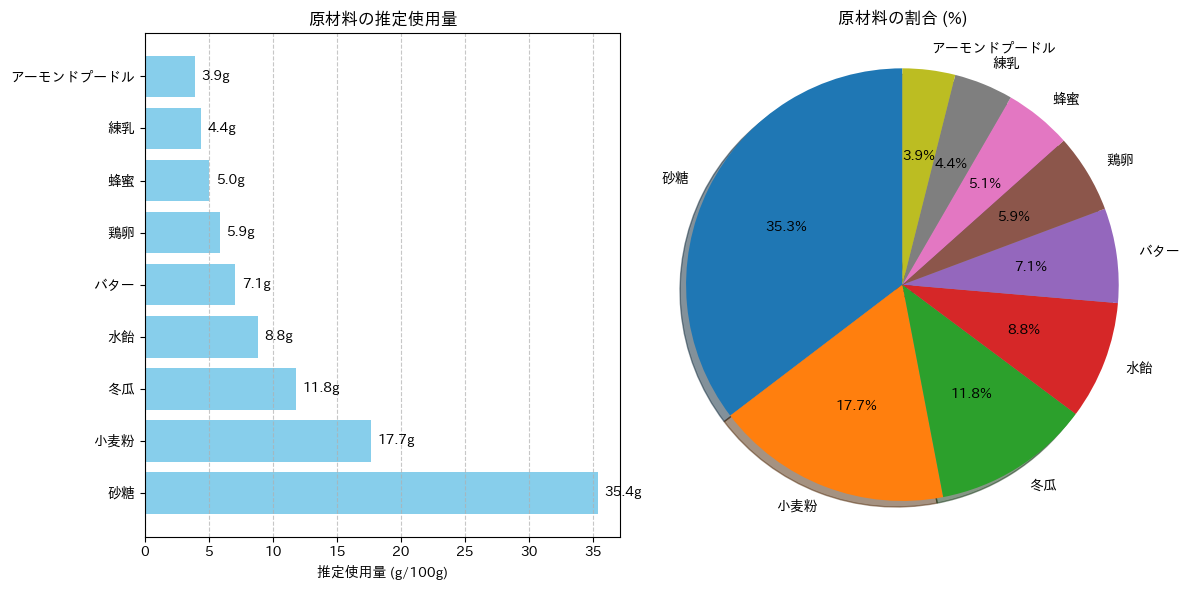

In [14]:
# 原材料の分量を推定
print("\n原材料の分量を推定中...")
estimated_amounts = estimate_ingredient_amounts(ingredients_df, target_nutrition)

# 結果表示
print("\n【推定使用量】")
display(estimated_amounts)

# 結果を可視化
visualize_results(estimated_amounts)

In [15]:
# 結果をJSON形式で出力
result_json = {
    "product_nutrition": target_nutrition,
    "ingredients": []
}

for i, row in estimated_amounts.iterrows():
    ingredient_info = next((item for item in ingredients_info['ingredients'] if item['name'] == row['原材料']), None)
    if ingredient_info:
        result_json["ingredients"].append({
            "name": row['原材料'],
            "estimated_amount_g": float(row['推定量(g)']),
            "percentage": float(row['割合(%)']),
            "display_order": int(row['表示順位']),
            "category": ingredient_info['category'],
            "nutrition_per_100g": ingredient_info['estimated_nutrition']
        })

print("\nJSON形式の結果:")
print(json.dumps(result_json, ensure_ascii=False, indent=2))


JSON形式の結果:
{
  "product_nutrition": {
    "calories": 376.9,
    "protein": 4.23,
    "fat": 10.38,
    "carbs": 66.15,
    "salt": 0.384,
    "total_amount": 100
  },
  "ingredients": [
    {
      "name": "砂糖",
      "estimated_amount_g": 35.35,
      "percentage": 35.35,
      "display_order": 1,
      "category": "炭水化物源",
      "nutrition_per_100g": {
        "calories": 387,
        "protein": 0,
        "fat": 0,
        "carbs": 100,
        "salt": 0
      }
    },
    {
      "name": "小麦粉",
      "estimated_amount_g": 17.67,
      "percentage": 17.67,
      "display_order": 2,
      "category": "炭水化物源",
      "nutrition_per_100g": {
        "calories": 364,
        "protein": 10,
        "fat": 1,
        "carbs": 76,
        "salt": 0.002
      }
    },
    {
      "name": "冬瓜",
      "estimated_amount_g": 11.78,
      "percentage": 11.78,
      "display_order": 3,
      "category": "炭水化物源",
      "nutrition_per_100g": {
        "calories": 19,
        "protein": 0.6,
      

## 8. 応用: API利用せずにテスト用の原材料データを直接入力する例


【テスト用データでの推定使用量】


,原材料,推定量(g),割合(%),表示順位
0,小麦粉,43.80,43.80,1
1,砂糖,21.90,21.90,2
2,バター,14.60,14.60,3
3,卵,10.95,10.95,4
4,食塩,8.76,8.76,5


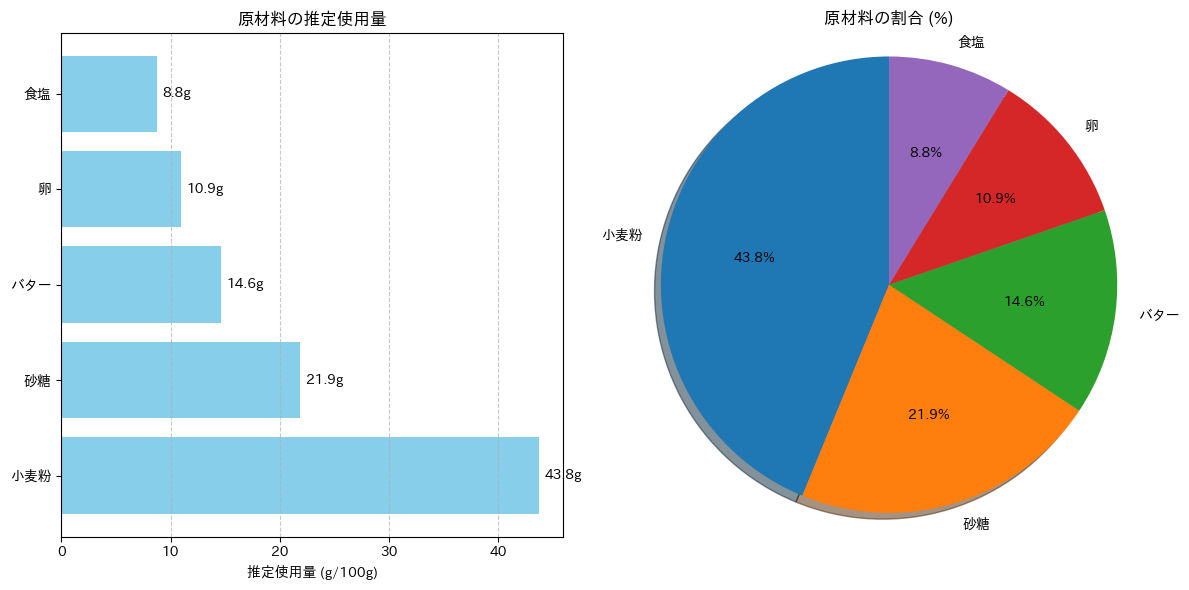

In [16]:
# APIを利用せずに直接原材料データを作成するテスト用関数
def create_test_ingredients_data():
    """テスト用に原材料データを作成する"""
    test_data = {
        "ingredients": [
            {
                "name": "小麦粉",
                "position": 1,
                "category": "炭水化物源",
                "estimated_nutrition": {
                    "calories": 350,
                    "protein": 8.0,
                    "fat": 2.0,
                    "carbs": 75.0,
                    "salt": 0.01
                }
            },
            {
                "name": "砂糖",
                "position": 2,
                "category": "炭水化物源",
                "estimated_nutrition": {
                    "calories": 384,
                    "protein": 0.0,
                    "fat": 0.0,
                    "carbs": 99.8,
                    "salt": 0.0
                }
            },
            {
                "name": "バター",
                "position": 3,
                "category": "脂質源",
                "estimated_nutrition": {
                    "calories": 740,
                    "protein": 0.5,
                    "fat": 81.0,
                    "carbs": 0.5,
                    "salt": 0.1
                }
            },
            {
                "name": "卵",
                "position": 4,
                "category": "タンパク質源",
                "estimated_nutrition": {
                    "calories": 150,
                    "protein": 12.5,
                    "fat": 10.5,
                    "carbs": 0.5,
                    "salt": 0.4
                }
            },
            {
                "name": "食塩",
                "position": 5,
                "category": "調味料",
                "estimated_nutrition": {
                    "calories": 0,
                    "protein": 0.0,
                    "fat": 0.0,
                    "carbs": 0.0,
                    "salt": 100.0
                }
            }
        ]
    }
    return test_data

# テスト用データ
test_ingredients_info = create_test_ingredients_data()
test_ingredients_df = ingredients_json_to_dataframe(test_ingredients_info)

# テスト用栄養成分
test_nutrition = {
    'calories': 400,
    'protein': 7.0,
    'fat': 12.0,
    'carbs': 70.0,
    'salt': 1.0,
    'total_amount': 100
}

# 分量を推定
test_estimated_amounts = estimate_ingredient_amounts(test_ingredients_df, test_nutrition)

# 結果表示
print("\n【テスト用データでの推定使用量】")
display(test_estimated_amounts)

# 結果を可視化
visualize_results(test_estimated_amounts)